### README
- methane_storage.pkl  containts the entire dataset with two keys 'inputs' and 'outputs'

- results for all methods are stored in corresponding [method_name]_results.pkl file
    - for e.g. bo results are stored in 'bo_results.pkl'
    - has three keys 'outputs', 'outputs_normalized', 'inputs_selected'
    - requires pytorch to open https://pytorch.org/

In [12]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### PCA low dimensional figure

In [2]:
# all COFs 
inputs =  pickle.load(open('methane_storage.pkl', 'rb'))['inputs']
for i in range(len(inputs[0])):
    inputs[:, i] = (inputs[:, i] - np.min(inputs[:, i]))/(np.max(inputs[:, i]) - np.min(inputs[:, i])) # same normalization as BO code
outputs =  pickle.load(open('methane_storage.pkl', 'rb'))['outputs'].values
#outputs = ((outputs - np.min(outputs))/(np.max(outputs)-np.min(outputs)))

In [3]:
# 2 dim PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(inputs)
inputs_low_dim_pca = pca.transform(inputs)

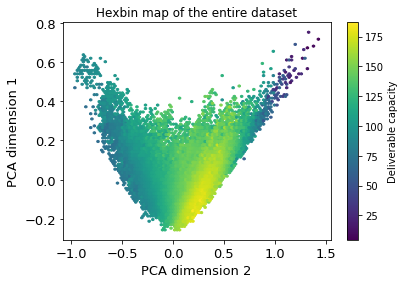

In [4]:
#low dimensional (PCA) visualization of the entire dataset
plt.hexbin(inputs_low_dim_pca[:, 0], inputs_low_dim_pca[:, 1],C=outputs)
plt.ylabel('PCA dimension 1', fontsize=13)
plt.xlabel('PCA dimension 2',fontsize=13)
plt.title('Hexbin map of the entire dataset', fontsize=12)
plt.colorbar(label="Deliverable capacity")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('Hexbin_pca_all_inputs_2dim.pdf')

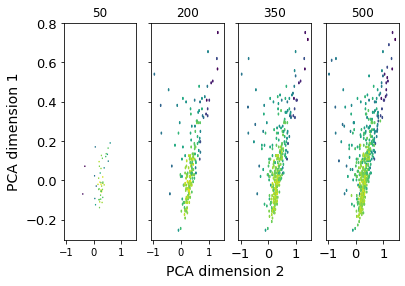

In [14]:
#low dimensional (PCA) visualization of the points selected by BO

# bo_results.pkl is a torch-compatible dictionary storing BO results
bo_data = torch.load('bo_results.pkl') 
inputs_selected = bo_data['inputs_selected'][0]
inputs_selected = pca.transform(inputs_selected) # PCA transform
bo_outputs = bo_data['outputs'][0]
#print(len(bo_outputs))
fig, ax = plt.subplots(1, 4, sharey=True, sharex=True)#, figsize=(14, 4))
ax[0].hexbin(inputs_selected[:50, 0], inputs_selected[:50, 1], C=bo_outputs[:50])
ax[0].set_ylabel('PCA dimension 1', fontsize=14)
ax[0].set_title('50')
ax[0].tick_params(axis='y', labelsize=13)

ax[1].hexbin(inputs_selected[:200, 0], inputs_selected[:200, 1], C=bo_outputs[:200])
ax[1].set_title('200')
ax[2].hexbin(inputs_selected[:350, 0], inputs_selected[:350, 1], C=bo_outputs[:350])
ax[2].set_title('350')
ax[2].tick_params(axis='both', labelsize=13)

ax[3].hexbin(inputs_selected[:500, 0], inputs_selected[:500, 1], C=bo_outputs[:500])
ax[3].set_title('500')
ax[3].tick_params(axis='x', labelsize=13)

fig.text(0.5, 0.001, 'PCA dimension 2', ha='center', fontsize=14)

plt.savefig("BO_over_time_pca_hexbin_0.pdf")

### BO vs Exploration vs Exploitation

In [6]:
def return_best_accumulated(data):
    best_accumulated_data = []
    for i in range(len(data)):
        best_accumulated_data.append(np.maximum.accumulate(data[i]))
    return np.array(best_accumulated_data)

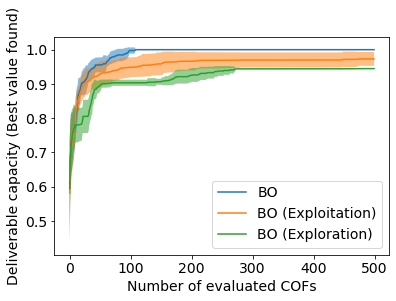

In [7]:
bo_data = return_best_accumulated(torch.load('bo_results.pkl')['outputs_normalized'])
exploitation_data = return_best_accumulated(torch.load('bo_exploitation_results.pkl')['outputs_normalized'])
exploration_data = return_best_accumulated(torch.load('bo_exploration_results.pkl')['outputs_normalized'])

plt.plot(list(range(500)), np.mean(bo_data, axis=0), label='BO')
plt.fill_between(list(range(500)), np.mean(bo_data, axis=0) - np.std(bo_data, axis=0), np.mean(bo_data, axis=0) + np.std(bo_data, axis=0), alpha=0.5)
plt.plot(list(range(500)), np.mean(exploitation_data, axis=0), label='BO (Exploitation)')
plt.fill_between(list(range(500)), np.mean(exploitation_data, axis=0) -  np.std(exploitation_data, axis=0), np.mean(exploitation_data, axis=0) + np.std(exploitation_data, axis=0), alpha=0.5)
plt.plot(list(range(500)), np.mean(exploration_data, axis=0), label='BO (Exploration)')
plt.fill_between(list(range(500)), np.mean(exploration_data, axis=0) - np.std(exploration_data, axis=0), np.mean(exploration_data, axis=0) + np.std(exploration_data, axis=0), alpha=0.5)
plt.xlabel('Number of evaluated COFs', fontsize=14)
plt.ylabel('Deliverable capacity (Best value found)', fontsize=14)
plt.legend(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("best_value_comparison_BO.pdf")


### BO vs ES vs RS vs RF ranking

In [8]:
def return_best_accumulated_ranking(data):
    outputs =  pickle.load(open('methane_storage.pkl', 'rb'))['outputs'].values
    outputs = ((outputs - np.min(outputs))/(np.max(outputs)-np.min(outputs)))
    outputs = np.sort(outputs)[::-1]
    best_ranked_data = []
    for i in range(len(data)):
        best_ranked_data.append(np.minimum.accumulate(np.log(np.minimum.accumulate([np.argwhere(x <= outputs)[-1][-1] for x in data[i]]) + 1)))
    return np.array(best_ranked_data)

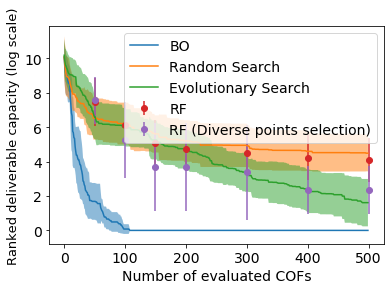

In [10]:
bo_data = return_best_accumulated_ranking(torch.load('bo_results.pkl')['outputs_normalized'])
# exploitation_data = return_best_accumulated_ranking(torch.load('bo_exploitation_results.pkl')['outputs_normalized'])
# exploration_data = return_best_accumulated_ranking(torch.load('bo_exploration_results.pkl')['outputs_normalized'])
es_data = return_best_accumulated_ranking(torch.load('es_results.pkl')['outputs_normalized'])
rf_data = return_best_accumulated_ranking(torch.load('rf_results.pkl')['outputs_normalized'])
diverse_rf_data = return_best_accumulated_ranking(torch.load('diverse_rf_results.pkl')['outputs_normalized'])


# Random Search
all_outputs =  pickle.load(open('../mofs_research/MOFs/methane_storage.pkl', 'rb'))['outputs'].values
all_outputs = ((all_outputs - np.min(all_outputs))/(np.max(all_outputs)-np.min(all_outputs)))
rs_data = []
for i in range(25):
    initial_random_idxs = np.random.choice(np.arange((inputs.shape[0])), size=500, replace=False)
    rs_data.append(all_outputs[initial_random_idxs])
rs_data = return_best_accumulated_ranking(rs_data)



plt.plot(list(range(500)), np.mean(bo_data, axis=0), label='BO')
plt.fill_between(list(range(500)), np.mean(bo_data, axis=0) - np.std(bo_data, axis=0), np.mean(bo_data, axis=0) + np.std(bo_data, axis=0), alpha=0.5)
# plt.plot(list(range(500)), np.mean(exploitation_data, axis=0), label='BO (Exploitation)')
# plt.fill_between(list(range(500)), np.mean(exploitation_data, axis=0) -  np.std(exploitation_data, axis=0), np.mean(exploitation_data, axis=0) + np.std(exploitation_data, axis=0), alpha=0.5)
# plt.plot(list(range(500)), np.mean(exploration_data, axis=0), label='BO (Exploration)')
# plt.fill_between(list(range(500)), np.mean(exploration_data, axis=0) - np.std(exploration_data, axis=0), np.mean(exploration_data, axis=0) + np.std(exploration_data, axis=0), alpha=0.5)


plt.plot(list(range(500)), np.mean(rs_data, axis=0), label='Random Search')
plt.fill_between(list(range(500)), np.mean(rs_data, axis=0) - np.std(rs_data, axis=0), np.mean(rs_data, axis=0) + np.std(rs_data, axis=0), alpha=0.5)

plt.plot(list(range(500)), np.mean(es_data, axis=0), label='Evolutionary Search')
plt.fill_between(list(range(500)), np.mean(es_data, axis=0) - np.std(es_data, axis=0), np.mean(es_data, axis=0) + np.std(es_data, axis=0), alpha=0.5)

plt.errorbar([50, 100, 150, 200, 300, 400, 500], np.mean(rf_data, axis=0), np.std(rf_data, axis=0), fmt='o', label='RF')
plt.errorbar([50, 100, 150, 200, 300, 400, 500], np.mean(diverse_rf_data, axis=0),  np.std(diverse_rf_data, axis=0), fmt='o', label='RF (Diverse points selection)')


plt.xlabel('Number of evaluated COFs', fontsize=14)
plt.ylabel('Ranked deliverable capacity (log scale)', fontsize=13)
plt.legend(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("best_value_comparison_BO.pdf")


### BO vs ES vs RS vs RF best accumulated

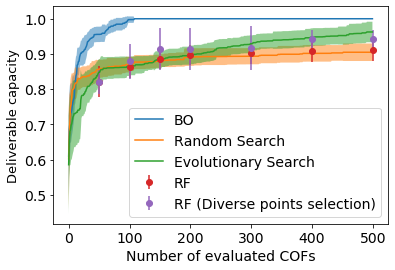

In [11]:
bo_data = return_best_accumulated(torch.load('bo_results.pkl')['outputs_normalized'])
# exploitation_data = return_best_accumulated(torch.load('bo_exploitation_results.pkl')['outputs_normalized'])
# exploration_data = return_best_accumulated(torch.load('bo_exploration_results.pkl')['outputs_normalized'])
es_data = return_best_accumulated(torch.load('es_results.pkl')['outputs_normalized'])
rf_data = return_best_accumulated(torch.load('rf_results.pkl')['outputs_normalized'])
diverse_rf_data = return_best_accumulated(torch.load('diverse_rf_results.pkl')['outputs_normalized'])


# Random Search
all_outputs =  pickle.load(open('../mofs_research/MOFs/methane_storage.pkl', 'rb'))['outputs'].values
all_outputs = ((all_outputs - np.min(all_outputs))/(np.max(all_outputs)-np.min(all_outputs)))
rs_data = []
for i in range(25):
    initial_random_idxs = np.random.choice(np.arange((inputs.shape[0])), size=500, replace=False)
    rs_data.append(all_outputs[initial_random_idxs])
rs_data = return_best_accumulated(rs_data)



plt.plot(list(range(500)), np.mean(bo_data, axis=0), label='BO')
plt.fill_between(list(range(500)), np.mean(bo_data, axis=0) - np.std(bo_data, axis=0), np.mean(bo_data, axis=0) + np.std(bo_data, axis=0), alpha=0.5)
# plt.plot(list(range(500)), np.mean(exploitation_data, axis=0), label='BO (Exploitation)')
# plt.fill_between(list(range(500)), np.mean(exploitation_data, axis=0) -  np.std(exploitation_data, axis=0), np.mean(exploitation_data, axis=0) + np.std(exploitation_data, axis=0), alpha=0.5)
# plt.plot(list(range(500)), np.mean(exploration_data, axis=0), label='BO (Exploration)')
# plt.fill_between(list(range(500)), np.mean(exploration_data, axis=0) - np.std(exploration_data, axis=0), np.mean(exploration_data, axis=0) + np.std(exploration_data, axis=0), alpha=0.5)


plt.plot(list(range(500)), np.mean(rs_data, axis=0), label='Random Search')
plt.fill_between(list(range(500)), np.mean(rs_data, axis=0) - np.std(rs_data, axis=0), np.mean(rs_data, axis=0) + np.std(rs_data, axis=0), alpha=0.5)

plt.plot(list(range(500)), np.mean(es_data, axis=0), label='Evolutionary Search')
plt.fill_between(list(range(500)), np.mean(es_data, axis=0) - np.std(es_data, axis=0), np.mean(es_data, axis=0) + np.std(es_data, axis=0), alpha=0.5)

plt.errorbar([50, 100, 150, 200, 300, 400, 500], np.mean(rf_data, axis=0), np.std(rf_data, axis=0), fmt='o', label='RF')
plt.errorbar([50, 100, 150, 200, 300, 400, 500], np.mean(diverse_rf_data, axis=0),  np.std(diverse_rf_data, axis=0), fmt='o', label='RF (Diverse points selection)')


plt.xlabel('Number of evaluated COFs', fontsize=14)
plt.ylabel('Deliverable capacity', fontsize=13)
plt.legend(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("best_value_comparison_BO.pdf")
